In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as sla


from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge
np.random.seed(42)

In [2]:
def f(x):
  """
  x - np.array of len=2
  """
  return np.sum(np.sin(x)**2)

Задача: миниизировать эту функцию градиентным спуском. Для этого:
1. Пишим ункцию рассчета градиента.
2. Проверим ее с помощью assert & np.allclose.
3. Пишим функцию градиентного спуска.
И тестируем.

In [3]:
def grad_f(x):
  grad_vector = 2*np.sin(x)*np.cos(x)
  return grad_vector
assert np.allclose(grad_f(np.array([1, 2])), np.array([0.90929743, -0.7568025])), "Mistake!"
np.allclose(grad_f(np.array([1, 2])), np.array([0.90929743, -0.7568025]))

True

In [4]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
  """
  Идея: берем базовую точку х0 и сдвигаем её в направлении, обратном градиенту на шаг lr. 
  Сохранем массив полученных точек и возвращаем его.
  """
  if x0 is None:
    x0 = np.random.random(2)
  history = []

  curr_x = x0.copy()
  for i in range(num_iter):
    entry = np.hstack((curr_x, f(curr_x)))
    history.append(entry)

    curr_x = curr_x - lr*grad_f(curr_x)
  return np.vstack(history)


In [5]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)
steps[0:5]

array([[0.37454012, 0.95071431, 0.79616281],
       [0.30644357, 0.85613058, 0.6615014 ],
       [0.24892042, 0.75712953, 0.53243858],
       [0.20116746, 0.65728931, 0.41321361],
       [0.16201067, 0.56055377, 0.30867597]])

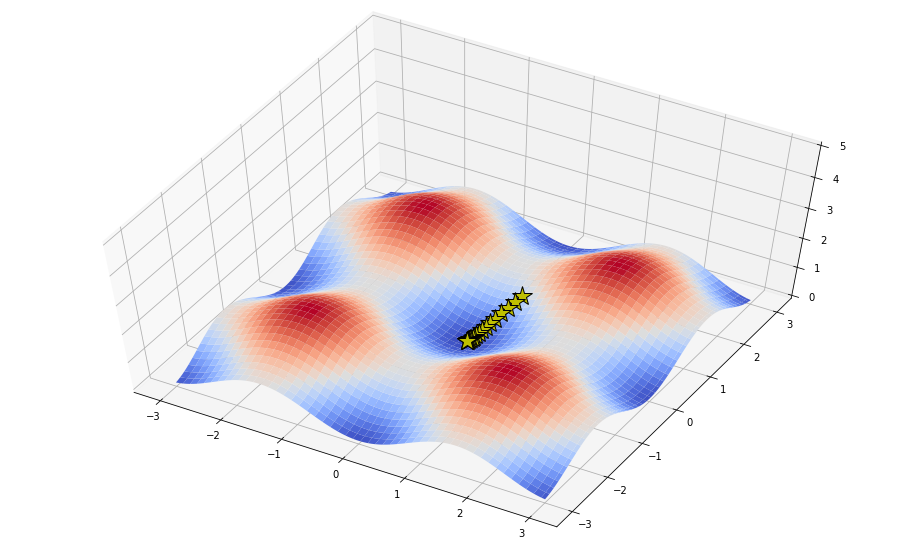

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

path = []
X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
fig = plt.figure(figsize=(16, 10))
ax = plt.gca(projection="3d")
zs = np.array([f(np.array([x,y]))
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='*', markersize=20, zorder=3, 
        markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()


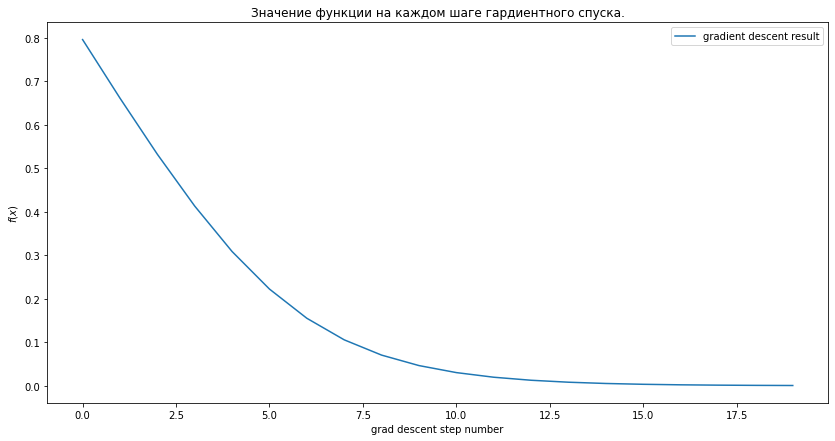

In [7]:
plt.figure(figsize=(14,7))
plt.xlabel('grad descent step number')
plt.ylabel('$f(x)$')
plt.title('Значение функции на каждом шаге гардиентного спуска.')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='gradient descent result')
plt.legend()

# Генератор батчей
Обычно генерация батчей отличается от той, которую мы использовали в семинаре. Мы выбирали batch_size случайных строчек на каждом шаге, но у такого подхода есть минусы. Основной заключается в том, что некоторые строчки из обучающего датасета могут попадаться значительно реже, чем другие.

Чтобы это исправить обучение делят на эпохи. Мы хотим, чтобы в течение одной эпохи модель обучилась на каждом примере один раз. Для этого нужно перемешать строчки в датасете и каждый раз брать очередные batch_size строчек.

Может так получится, что размер датасета не делится на batch_size, тогда последний батч будет состоять из нескольких последних строк и его размер будет меньше, чем batch_size. Такой батч иногда выкидывают и просто не используют. Именно так вам нужно поступить в этом задании.

In [33]:
def generate_batches(X, y , batch_size):
  """
  Идея: получаем признаки и целевые значения, возвращаем tuple
  """
  assert len(X) == len(y)
  np.random.seed(42)
  X = np.array(X)
  y = np.array(y)
  perm = np.random.permutation(len(X))

  for batch_start in range(0, len(X), batch_size):
    X_result, y_result = [], []
    if (batch_start + batch_size) <= len(X):
      for i in range(batch_size):
        X_result.append(X[perm[batch_start + i]])
        y_result.append(y[perm[batch_start + i]])
      yield (np.array(X_result), np.array(y_result))


ٌКак я хорош!!!

In [9]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)
X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Что-то не так!"
assert (y_fake != y_reconstructed).all(), "Что-то не так!"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Что-то не так!"


In [10]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Что-то не так!"

# Логистическая регрессия

Функция потерь:

$$-∑y_i*ln(f(x)) + (1-y_i)*ln(1-f(x))$$
где f(x) - предсказанная вероятность вида:
$$f(x) = \sigma(w*x) = \frac{1}{1+e^{-∑w_i*x_i}} = sigmoid(logit(w,x))$$


In [11]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))
    

In [65]:
class MyLogisticRegression(object):
  def __init__(self):
    self.w = None
  
  def fit(self, X, y, epochs, lr, batch_size):
    """
    Здесь мы балансируем веса, минимизируя функцию лосса. Лоссы сохраняем по батчам в лист losses.
    Сначала делаем цикл с эпохами. В них генерируем батчи. В батчах делаем предсказания по формулам logit & sigmoid, затем считаем лоссы по формуле сверху.
    Затем балансируем self.w с помощью get_grad. возвращаем лоссы, ну и веса self.w обновились во тьме.
    """
    n,k = X.shape
    if self.w is None:
      np.random.seed(42)
      self.w = np.random.randn(k + 1) # Вектор столбец в качестве весов, + свободный член
    X_train = np.concatenate((np.ones((n, 1)), X), axis=1)

    losses = []
    for epoch in range(epochs):
      for X_batch, y_batch in generate_batches(X_train, y, batch_size):
        predictions = self.pred_proba(X_batch) # Просто композиция функций по формуле выше
        loss = self.__loss(y_batch, predictions)
        assert (np.array(loss).shape == tuple()), "Лосс должен быть скаляром!"
        losses.append(loss)
        self.w = self.w - lr*self.get_grad(X_batch, y_batch, predictions)
    return losses

  def get_grad(self, X_batch, y_batch, predictions):
        """
        param X_batch: np.array[batch_size, n_features + 1] --- матрица объекты-признаки
        param y_batch: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        Выдаёт градиент функции потерь в логистической регрессии
        как сумму градиентов функции потерь на всех объектах батча
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака. 
        Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма. 
        В качестве оператора умножения матриц можно использовать @ 

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """

        #компонент градиента из логрегрессии 
        #следите за размерностями
        
        grad_basic = - X_batch.transpose() @ (y_batch - predictions)
        assert grad_basic.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic

  def pred_proba(self, X):
    n, k = X.shape
    if k != self.w.size:
      X = np.concatenate((np.ones((n, 1)), X), axis=1) #Я не знаю, зачем. По идее мы это уже делали.
    return sigmoid(logit(X, self.w))

  def predict(self, X, threshold=0.5):
        return self.pred_proba(X) >= threshold
    
  def get_weights(self):
        return self.w.copy() 
        # copy тут используется неспроста. Если copy не использовать, то get_weights()
        # выдаст ссылку на объект, а, значит, модифицируя результат применения функции
        # get_weights(), вы модифицируете и веса self.w. Если вы хотите модифицировать веса, 
        # (например, в fit), используйте self.w
  def __loss(self, y, pred):
    return -np.sum(y * np.log(pred)+(1 - y) * np.log(1 - pred))

In [13]:
m = MyLogisticRegression()
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
grads = m.get_grad(X, y, preds) 
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "Что-то не так!"

In [14]:
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds) 
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Что-то не так!"



---



# Логистическая регрессия с $l_1$ и $l_2$ регуляризацией (elastic net).

Ваша задача -- написать класс логистической регрессии с обеими регуляризациями и оптимизацией с помощью SGD, используя генератор батчей, который вы написали выше.

Обратите внимание, что реализация ElasticNet отличается от реализации LogisticRegression только функцией потерь для оптимизации. Поэтому единственная функция, которая будет отличаться у двух методов, это ``self.get_grad()``. 

Поэтому в данном случае естественно применить паттерн *наследования*. Весь синтаксис наследования мы прописали за вас. Единственное, что вам осталось сделать, это переопределить метод ``get_grad()`` в отнаследованном классе.

## Задание 4
Реализуйте метод ``get_grad()`` класса ``MyElasticLogisticRegression`` 

Формулы:

$$L_1 (w) = \alpha \sum_{j=1}^{n}|w_j| $$

$$L_2 (w) = \beta\sum_{j=1}^{n}w_j^2$$

$$\frac{\partial L_1}{\partial w_1} = \alpha \cdot \mathrm{sign}(w_1)$$

$$ \frac{\partial L_2}{\partial w_1} = 2\beta w_1$$


In [66]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None
    
    def get_grad(self, X_batch, y_batch, predictions):
        """
        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        Выдаёт градиент функции потерь в логистической регрессии с регуляризаторами
        как сумму градиентов функции потерь на всех объектах батча + регуляризационное слагаемое
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака. 
        Bias в регуляризационные слагаемые не входит. Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма. 
  
        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """


        grad_basic = - X_batch.transpose() @ (y_batch - predictions) #компонент градиента из логрегрессии. Обнулять bias-компоненту этой составляющей градиента не нужно!

        grad_l1 = self.l1_coef * np.sign(self.w)#YOUR CODE: компонент градиента из l_1-регуляризации (не забудьте обнулить компоненту с bias)
        grad_l2 = 2 * self.l2_coef * self.w #YOUR CODE: компонент градиента из l_2-регуляризации (не забудьте обнулить компоненту с bias)

        #Обнулять bias-компоненту вектора весов не нужно!
        grad_l1[0] = 0
        grad_l2[0] = 0
        assert grad_l1[0] == grad_l2[0] == 0, "Bias в регуляризационные слагаемые не входит!"
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"
        
        return grad_basic + grad_l1 + grad_l2

In [18]:
m = MyElasticLogisticRegression(.2,.2) 
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.82, -2.6 , -0.33])), "Что-то не так!"


In [19]:
np.random.seed(42)
m = MyElasticLogisticRegression(.2, .2)
X = np.random.rand(100,3)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([49.11489408, 24.4698149, 25.87049356, 25.0139452])), "Что-то не так!"


Теперь тестируем на реальных данных. Сначала генерируем облако точек, потом возьмем какой-нибудь датасет.

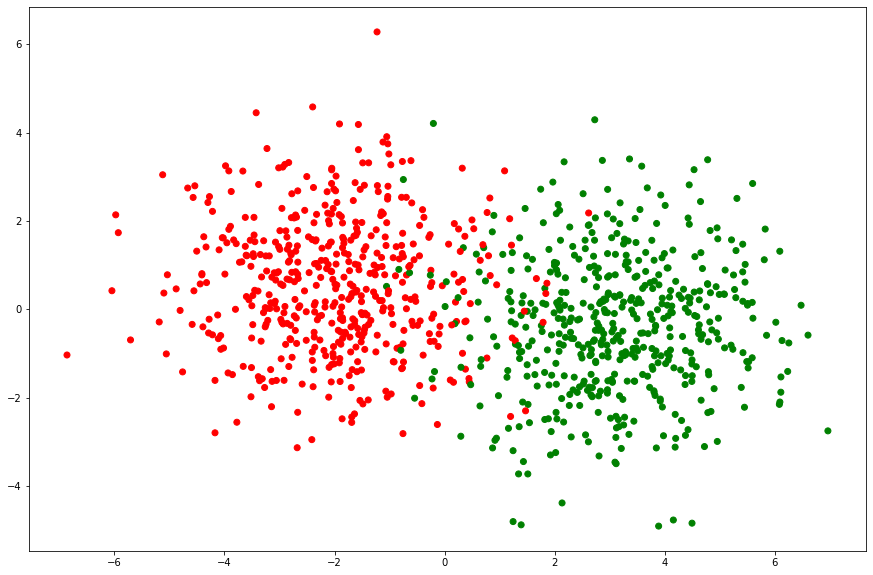

In [24]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1.5, random_state=42)
colors = ['red', 'green']
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply


(40000,) (40000,)


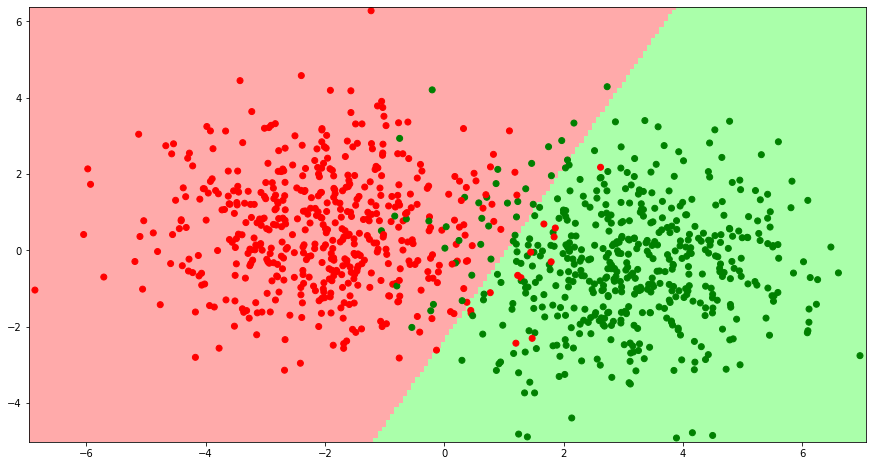

In [68]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, lr=0.5, batch_size=10, epochs=1000)
w = clf.get_weights()

from matplotlib.colors import ListedColormap

plt.figure(figsize=(15, 8))
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
print(xx.ravel().shape, yy.ravel().shape)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)